/root/algo_seminar/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


/tmp/ipykernel_9950/3843930158.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded: Epoch 274, Loss: 0.012378733668286922


100%|██████████| 118/118 [00:25<00:00,  4.55it/s]


Epoch 274 | Loss: 0.012458232555033292
Checkpoint saved at data/FashionMNIST/checkpoint_epoch_274.pth


1000it [00:08, 124.05it/s]


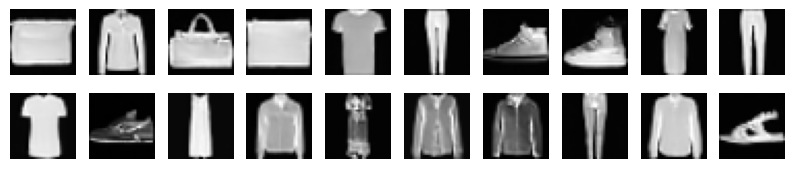

 19%|█▉        | 23/118 [00:05<00:20,  4.55it/s]


KeyboardInterrupt: 

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from diffusers import UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Hyperparameters
img_size = 32
batch_size = 512
max_steps = 1000
lr = 1e-3
epochs = 1000

def prepare_dataset_with_labels(batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    # FashionMNISTデータセットの読み込み
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=transform)

    # クラスラベルのマッピング
    labels = {
        0: "T-shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

    # DataLoaderの作成
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader, labels

def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for _ in range(rows):
        for _ in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()

def diffusion_process(scheduler, model, text_embeddings):
    samples = torch.randn((20, 1, img_size, img_size), device=device)
    for _, t in tqdm(enumerate(scheduler.timesteps)):
        samples = scheduler.step(model(samples, t, encoder_hidden_states=text_embeddings).sample, t, samples).prev_sample
    return samples

def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: Epoch {epoch}, Loss: {loss}")
    return epoch, loss

# Select device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

# Prepare dataset and labels
dataloader, labels = prepare_dataset_with_labels(batch_size)  # Ensure labels are loaded

# Initialize model, CLIP, and scheduler
model = UNet2DConditionModel(
    sample_size=img_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    cross_attention_dim=512  # Match CLIP's embedding size
).to(device)

# Scheduler for Diffusion
scheduler = DDPMScheduler(num_train_timesteps=max_steps)

# CLIP components
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)

# Checkpoint path
checkpoint_path = "data/FashionMNIST/checkpoint_epoch_274.pth"  # 例: 10エポック目のチェックポイント

# Load checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)

# Training loop
losses = []
for epoch in range(start_epoch, epochs):
    model.train()
    loss_sum = 0.0
    cnt = 0
    for images, lbls in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(0, max_steps, (len(x),), device=device)  # Randam time step
        noise = torch.randn_like(x)                                # Generate random noise
        noisy_images = scheduler.add_noise(x, noise, t)            # Add noise to images

        # ラベルテンソルからプロンプトを生成
        prompts = [labels[lbl.item()] for lbl in lbls]

        # テキスト埋め込みの取得
        tokens = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        text_embeddings = text_encoder(**tokens).last_hidden_state

        # Predict noise using cross-attention
        noise_pred = model(noisy_images, t, encoder_hidden_states=text_embeddings).sample

        # Diffusion
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

    # Save model checkpoint
    checkpoint_path = f"data/FashionMNIST/checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_avg,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    # Plot losses
    # plt.plot(losses)
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.show()

    # Generate and visualize samples with last batch
    model.eval()
    with torch.no_grad():
        samples = diffusion_process(scheduler, model, text_embeddings[:20]).to('cpu')

    show_images([sample[0] for sample in samples])

# Save model
model.save_pretrained("data/FashionMNIST/")


1000it [00:07, 125.02it/s]


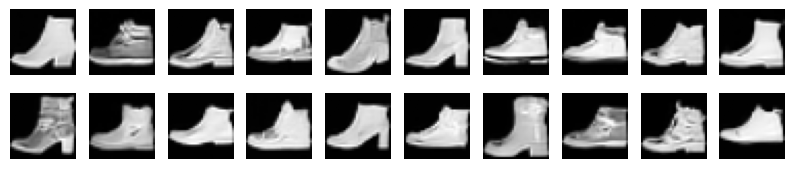

In [29]:
    # Generate and visualize samples
    def generate_image(prompt):
        model.eval()
        with torch.no_grad():
            prompts = [prompt] * 20
            # テキスト埋め込みの取得
            tokens = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
            text_embeddings = text_encoder(**tokens).last_hidden_state
            samples = torch.randn((20, 1, img_size, img_size), device=device)
            for i, t in tqdm(enumerate(scheduler.timesteps)):
                samples = scheduler.step(model(samples, t, encoder_hidden_states=text_embeddings).sample, t, samples).prev_sample

        show_images([sample[0] for sample in samples.to('cpu')])

generate_image("Ankle Boot")



In [42]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from diffusers import UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Hyperparameters
img_size = 32
batch_size = 512
max_steps = 1000
lr = 1e-3
epochs = 1000

def prepare_dataset_with_labels(batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    # FashionMNISTデータセットの読み込み
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=transform)

    # クラスラベルのマッピング
    labels = {
        0: "T-shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

    # DataLoaderの作成
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader, labels

def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for _ in range(rows):
        for _ in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()

def diffusion_process(scheduler, model, text_embeddings):
    samples = torch.randn((20, 1, img_size, img_size), device=device)
    for _, t in tqdm(enumerate(scheduler.timesteps)):
        samples = scheduler.step(model(samples, t, encoder_hidden_states=text_embeddings).sample, t, samples).prev_sample
    return samples

def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: Epoch {epoch}, Loss: {loss}")
    return epoch, loss

# Select device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

# Prepare dataset and labels
dataloader, labels = prepare_dataset_with_labels(batch_size)  # Ensure labels are loaded

# Initialize model, CLIP, and scheduler
model = UNet2DConditionModel(
    sample_size=img_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    cross_attention_dim=512  # Match CLIP's embedding size
).to(device)

# Scheduler for Diffusion
scheduler = DDPMScheduler(num_train_timesteps=max_steps)

# CLIP components
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)

# Checkpoint path
#checkpoint_path = "data/FashionMNIST/checkpoint_epoch_274.pth"  # 例: 10エポック目のチェックポイント

# Load checkpoint if exists
#start_epoch = 0
#if os.path.exists(checkpoint_path):
#    start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)

from torchdiffeq import odeint

# Neural ODE用スケジューラ
class ODEScheduler:
    def __init__(self, model, scheduler):
        self.model = model
        self.scheduler = scheduler

    def ode_func(self, data, t):
        """
        ODE関数：モデルによるdx/dtの計算
        """
        x, text_embeddings = data
        print(x.size())
        print(text_embeddings.size())

        time_step = int(t.item() * self.scheduler.num_train_timesteps)
        time_step = max(0, min(time_step, self.scheduler.num_train_timesteps - 1))

        noise_pred = self.model(x, time_step, encoder_hidden_states=text_embeddings).sample
        alpha_t = self.scheduler.alphas_cumprod[time_step]
        beta_t = 1 - alpha_t

        dxdt = -beta_t * noise_pred / torch.sqrt(alpha_t)
        return dxdt

    def reverse_process(self, noisy_images, t_span, text_embeddings):
        """
        ODEソルバーでノイズからデータを復元
        """
        y0 = (noisy_images, text_embeddings)  # タプル形式で初期状態を設定
        solution = odeint(self.ode_func, y0, t_span, method='dopri5')
        return solution[-1][0]  # 最終的なノイズ除去画像を返す

# Neural ODEを用いた学習ループ
losses = []
ode_scheduler = ODEScheduler(model, scheduler)

for epoch in range(start_epoch, epochs):
    model.train()
    loss_sum = 0.0
    cnt = 0
    for images, lbls in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(0, max_steps, (len(x),), device=device)  # ランダム時刻
        noise = torch.randn_like(x)                                # ランダムノイズ
        noisy_images = scheduler.add_noise(x, noise, t)            # ノイズを追加

        # ラベルテンソルからプロンプトを生成
        prompts = [labels[lbl.item()] for lbl in lbls]

        # テキスト埋め込みを取得
        tokens = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        text_embeddings = text_encoder(**tokens).last_hidden_state

        # ODEプロセスを学習
#        t_span = torch.linspace(1, 0, 10, device=device)
        t_span = torch.linspace(1, 0, steps=50, device=device)
        print(t_span.size())
        denoised_images = ode_scheduler.reverse_process(noisy_images, t_span, text_embeddings)

        # 損失関数（MSE）
        loss = F.mse_loss(denoised_images[-1], x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

    # チェックポイント保存
    checkpoint_path = f"data/FashionMNIST/checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_avg,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    # サンプル生成と可視化
    model.eval()
    with torch.no_grad():
        samples = ode_scheduler.reverse_process(noisy_images, t_span, text_embeddings)[-1].cpu()

    show_images([sample[0] for sample in samples])

cuda


  0%|          | 0/118 [00:00<?, ?it/s]


torch.Size([50])


TypeError: iteration over a 0-d tensor